In [1]:
import os
import sys
import time
import math
import numpy as np
from glob import glob

import logging
import warnings

warnings.filterwarnings("ignore")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

logging.getLogger("tensorflow").setLevel(logging.ERROR) 

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import vae_utils as vu
import model_utils as mu

In [5]:
#from skimage.transform import resize

In [6]:
print('tf.version = {}'.format(tf.__version__))
print('tf on GPU = {}'.format(tf.test.is_gpu_available()))

tf.version = 2.12.1
tf on GPU = True


In [7]:
# Kernel initializer to use
def kernel_init(scale):
    scale = max(scale, 1e-10)
    return keras.initializers.VarianceScaling(
        scale, mode="fan_avg", distribution="uniform"
    )

class TimeEmbedding(layers.Layer):
    def __init__(self, dim, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.half_dim = dim // 2
        self.emb = math.log(10000) / (self.half_dim - 1)
        self.emb = tf.exp(tf.range(self.half_dim, dtype=tf.float32) * -self.emb)

    def call(self, inputs):
        inputs = tf.cast(inputs, dtype=tf.float32)
        emb = inputs[:, None] * self.emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb


def ResidualBlock(width, activation_fn=keras.activations.relu):
    def apply(inputs):
        x, t = inputs
        input_width = x.shape[3]

        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(
                width, kernel_size=1, kernel_initializer=kernel_init(1.0)
            )(x)

        temb = activation_fn(t)
        temb = layers.Dense(width, kernel_initializer=kernel_init(1.0))(temb)[
            :, None, None, :
        ]

        x = layers.BatchNormalization()(x)
        x = activation_fn(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0)
        )(x)

        x = layers.Add()([x, temb])
        x = layers.BatchNormalization()(x)
        x = activation_fn(x)

        x = layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(0.0)
        )(x)
        x = layers.Add()([x, residual])
        return x

    return apply

def TimeMLP(units, activation_fn=keras.activations.relu):
    def apply(inputs):
        temb = layers.Dense(
            units, activation=activation_fn, kernel_initializer=kernel_init(1.0)
        )(inputs)
        temb = layers.Dense(units, kernel_initializer=kernel_init(1.0))(temb)
        return temb

    return apply

In [8]:
filter_nums = [64, 128, 256] #[32, 64, 128]
activation = 'relu'
input_size = (256, 576, 8)
latent_size = (32, 72, filter_nums[-1])

model_name_save = '/glade/work/ksha/GAN/models/BC_{}_{}_{}_base'.format(filter_nums[0], 
                                                                        filter_nums[1], 
                                                                        activation)

time_input = keras.Input(shape=(), dtype=tf.int64)
temb = TimeEmbedding(dim=filter_nums[0]*4)(time_input)
temb = TimeMLP(units=filter_nums[0]*4)(temb)

# encoder
encoder_in = keras.Input(shape=input_size)
X = encoder_in

X = layers.Conv2D(filter_nums[0], 3, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = layers.Conv2D(filter_nums[0], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = ResidualBlock(filter_nums[0],)([X, temb])
X = ResidualBlock(filter_nums[0],)([X, temb])

X = layers.Conv2D(filter_nums[1], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = ResidualBlock(filter_nums[1],)([X, temb])
X = ResidualBlock(filter_nums[1],)([X, temb])

X = layers.Conv2D(filter_nums[2], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = ResidualBlock(filter_nums[2],)([X, temb])
X = ResidualBlock(filter_nums[2],)([X, temb])
encoder_out = X

model_encoder = keras.Model([encoder_in, time_input], encoder_out)

# decoder
decoder_in = keras.Input(shape=latent_size)

time_input = keras.Input(shape=(), dtype=tf.int64)
temb = TimeEmbedding(dim=filter_nums[0]*4)(time_input)
temb = TimeMLP(units=filter_nums[0]*4)(temb)

X = decoder_in

X = layers.Conv2DTranspose(filter_nums[2], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = ResidualBlock(filter_nums[2],)([X, temb])
X = ResidualBlock(filter_nums[2],)([X, temb])

X = layers.Conv2DTranspose(filter_nums[1], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = ResidualBlock(filter_nums[1],)([X, temb])
X = ResidualBlock(filter_nums[1],)([X, temb])

X = layers.Conv2DTranspose(filter_nums[0], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = ResidualBlock(filter_nums[0],)([X, temb])
X = ResidualBlock(filter_nums[0],)([X, temb])

decoder_out = layers.Conv2D(1, 1, padding="same")(X)

model_decoder = keras.Model([decoder_in, time_input], decoder_out)

# BC network
time_input = keras.Input(shape=(), dtype=tf.int64)

IN = keras.Input(shape=input_size)
X_encode = model_encoder([IN, time_input])
OUT = model_decoder([X_encode, time_input])
model = keras.Model([IN, time_input], OUT)

In [17]:
model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(learning_rate=1e-6))

In [25]:
W_old = mu.dummy_loader(model_name_save)
model.set_weights(W_old)

In [19]:
#

In [20]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [21]:
BATCH_dir = '/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/'

In [22]:
L_valid = 100

filenames = np.array(sorted(glob(BATCH_dir+'*.npy')))
L = len(filenames)

filename_valid = filenames[:L_valid]
#filename_valid = filenames[-L_valid:]
filename_train = list(set(filenames) - set(filename_valid))
L_train = len(filename_train)

Y_valid = np.empty((L_valid, 256, 576, 1))
X_valid = np.empty((L_valid, 256, 576, 8))
T_valid = np.empty((L_valid,))

for i, name in enumerate(filename_valid):
    temp_data = np.load(name)
    Y_valid[i, ..., 0] = temp_data[0, ..., 0]
    X_valid[i, ...] = temp_data[0, ..., 2:]
    T_valid[i] = int(name[-13:-11])

In [23]:
name[-13:-11]

'03'

In [24]:
epochs = 999
L_train = 64
batch_size = 32 #64

min_del = 0.0
max_tol = 3 # early stopping with 2-epoch patience
tol = 0

Y_batch = np.empty((batch_size, 256, 576, 1))
Y_batch[...] = np.nan

X_batch = np.empty((batch_size, 256, 576, 8))
X_batch[...] = np.nan

T_batch = np.empty((batch_size,))
T_batch[...] = np.nan

for i in range(epochs):
    print('epoch = {}'.format(i))
    if i == 0:
        Y_pred = model.predict([X_valid, T_valid])
        record = mean_absolute_error(Y_valid, Y_pred)
        print('Initial validation loss: {}'.format(record))
    
    start_time = time.time()
    for j in range(L_train):
        inds_rnd = du.shuffle_ind(L_train)
        inds_ = inds_rnd[:batch_size]

        for k, ind in enumerate(inds_):
            # import batch data
            name = filename_train[ind]
            temp_data = np.load(name)
            Y_batch[k, ..., 0] = temp_data[0, ..., 0]
            X_batch[k, ...] = temp_data[0, ..., 2:]
            T_batch[k] = int(name[-13:-11])
            
        model.train_on_batch([X_batch, T_batch], Y_batch)
        
    # on epoch-end
    Y_pred = model.predict([X_valid, T_valid])
    record_temp = mean_absolute_error(Y_valid, Y_pred)

    if record - record_temp > min_del:
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        model.save(model_name_save)
        
    else:
        print('Validation loss {} NOT improved'.format(record_temp))

    print("--- %s seconds ---" % (time.time() - start_time))
    # mannual callbacks

epoch = 0
4/4 [==============================] - 1s 233ms/step
Initial validation loss: 0.046983326874422
4/4 [==============================] - 1s 214ms/step
Validation loss 0.04699228415075171 NOT improved
--- 93.71694302558899 seconds ---
epoch = 1
4/4 [==============================] - 1s 214ms/step
Validation loss 0.04716768335053384 NOT improved
--- 76.39296078681946 seconds ---
epoch = 2
4/4 [==============================] - 1s 214ms/step
Validation loss 0.04769659433376359 NOT improved
--- 76.4679901599884 seconds ---
epoch = 3
4/4 [==============================] - 1s 215ms/step
Validation loss 0.04815119242935316 NOT improved
--- 76.49727082252502 seconds ---
epoch = 4
4/4 [==============================] - 1s 214ms/step
Validation loss 0.04710950148701213 NOT improved
--- 76.47478032112122 seconds ---
epoch = 5
4/4 [==============================] - 1s 214ms/step
Validation loss 0.047794385388525575 NOT improved
--- 76.56966066360474 seconds ---
epoch = 6
4/4 [=============


KeyboardInterrupt



In [26]:
Y_pred = model.predict([X_valid, T_valid])
print(np.mean(np.abs((np.exp(Y_valid[..., 0])-1))))
print(np.mean(np.abs((np.exp(Y_valid[..., 0])-1) - (np.exp(X_valid[..., 0])-1))))
print(mean_absolute_error(np.exp(Y_valid)-1, np.exp(Y_pred)-1))

4/4 [==============================] - 1s 233ms/step
0.17077332526312944
0.19419228328609853
0.13241550186868462


In [53]:
Y_pred = model.predict([X_valid, T_valid])
print(np.mean(np.abs((np.exp(Y_valid[..., 0])-1))))
print(np.mean(np.abs((np.exp(Y_valid[..., 0])-1) - (np.exp(X_valid[..., 0])-1))))
print(mean_absolute_error(np.exp(Y_valid)-1, np.exp(Y_pred)-1))

4/4 [==============================] - 1s 161ms/step
0.17077332526312944
0.19419228328609853
0.13321013748892604


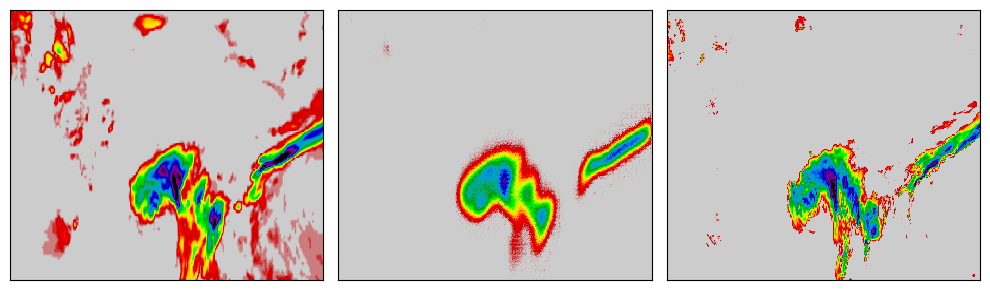

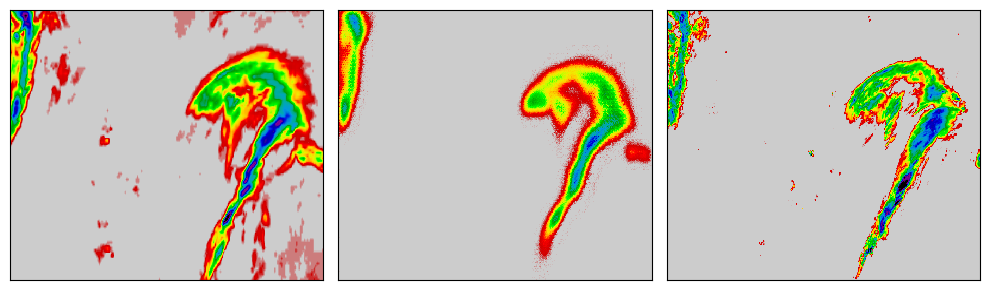

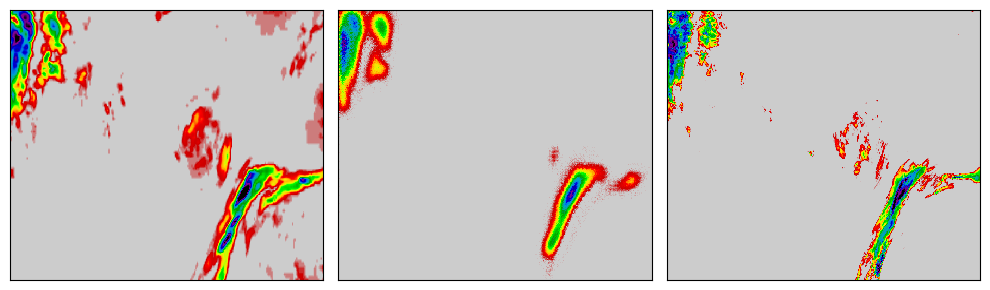

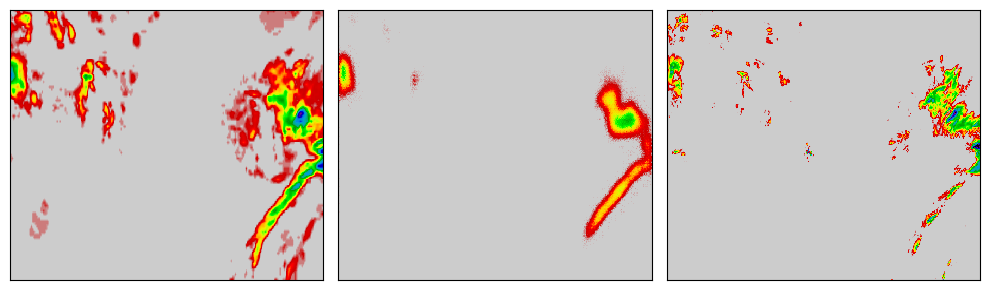

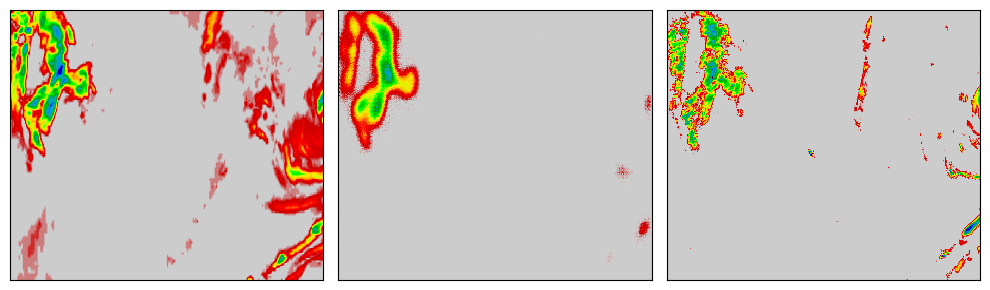

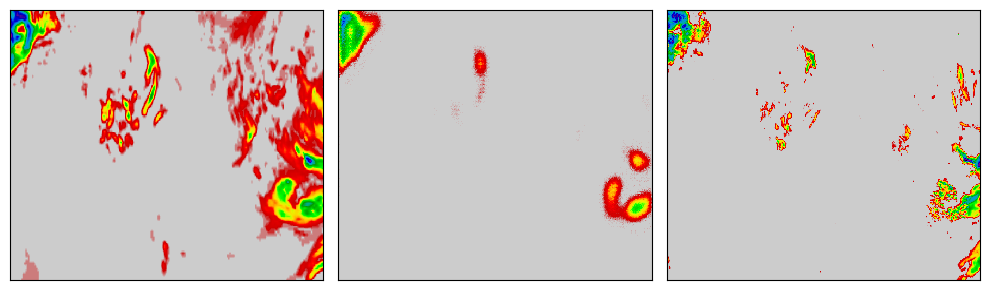

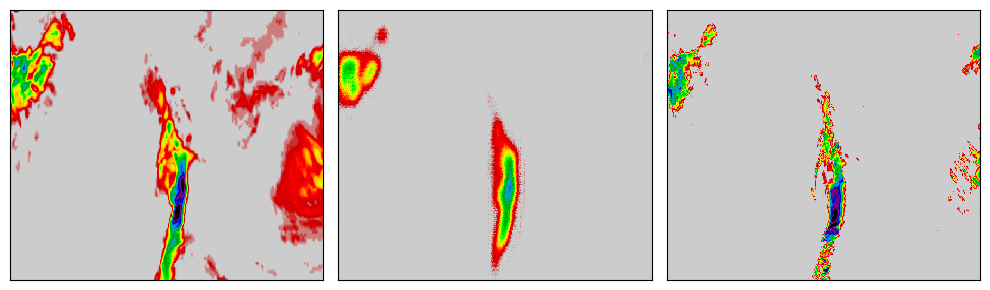

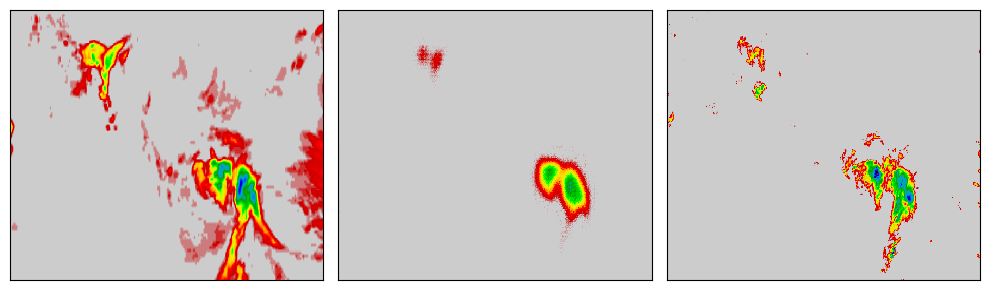

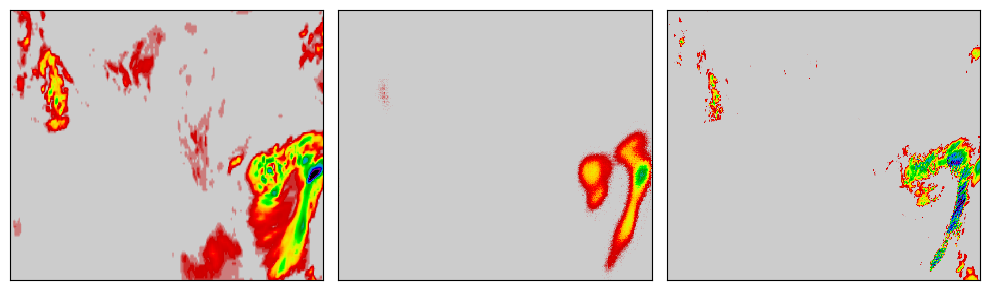

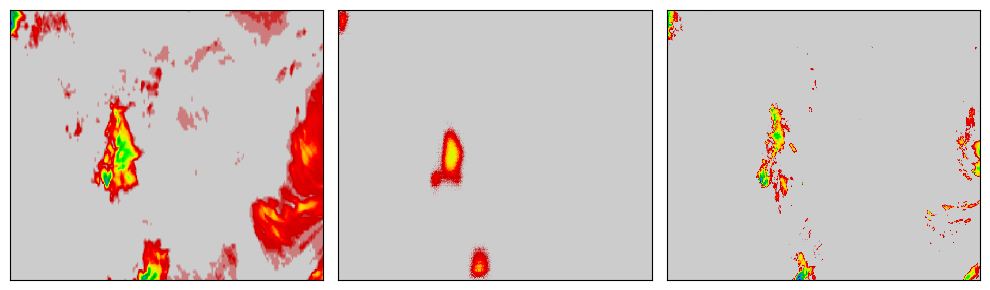

In [27]:
for i in range(10):

    fig, AX = plt.subplots(1, 3, figsize=(10, 3))
    
    for ax in AX:
        ax.tick_params(axis="both", which="both", bottom=False, 
                       top=False, labelbottom=False, left=False,
                       right=False, labelleft=False)
    plt.tight_layout()
    
    AX[0].pcolormesh(X_valid[i, ..., 0], vmin=0, vmax=3, cmap=plt.cm.nipy_spectral_r)
    AX[1].pcolormesh(Y_pred[i, ..., 0], vmin=0, vmax=3, cmap=plt.cm.nipy_spectral_r)
    AX[2].pcolormesh(Y_valid[i, ..., 0], vmin=0, vmax=3, cmap=plt.cm.nipy_spectral_r)